# ELECTRA Multi-lingual Model

### This notebook contains the implementation of the ELECTRA model pre-trained on the multi-lingual language set coming from `Datasets/ELECTRA/train_en.csv`

### The following steps are taken to establish the model
- **Data exploration and visualization**
- **Model definition**
- **Optimizer algorithm selection**
- **Loss function selection**
- **Training loop**
- **Model saving**

In [1]:
!pip install -q keras-nlp --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.1/644.1 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 106.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [2]:
import matplotlib.pyplot as plt
import pandas
import numpy
import keras_nlp
import keras
import tensorflow
import os
import re
import sklearn.metrics

keras.mixed_precision.set_global_policy("mixed_float16")

label_names = ["entailment", "neutral", "contradiction"]

#### Data Exploration and Visualization

In [3]:
electra_multi_dataset = pandas.read_csv("train_all_languages.csv")

electra_multi_dataset["premise"] = electra_multi_dataset["premise"].apply(lambda x: x.lower())

electra_multi_dataset["hypothesis"] = electra_multi_dataset["hypothesis"].apply(lambda x: x.lower())

spec_char_regex = r"[.!?,:;\"{}\[\]\(\)\~<>|\\/+*/@#$%^]+"
electra_multi_dataset["premise"] = electra_multi_dataset["premise"].replace(to_replace=spec_char_regex, value="", regex=True)

electra_multi_dataset["hypothesis"] = electra_multi_dataset["hypothesis"].replace(to_replace=spec_char_regex, value="", regex=True)

numbers_regex = r"[0-9]+"
electra_multi_dataset["premise"] = electra_multi_dataset["premise"].replace(to_replace=numbers_regex, value="", regex=True)

electra_multi_dataset["hypothesis"] = electra_multi_dataset["hypothesis"].replace(to_replace=numbers_regex, value="", regex=True)

electra_multi_dataset.head()

,Unnamed: 0,id,premise,hypothesis,lang_abv,language,label,label_name
0,0,f4891fa23f,кто она спросила его с неожиданным интересом,она спросила как это сделать так как с её точк...,ru,Russian,1,neutral
1,1,e8b38c6175,others are zao in tohoku and a number of resor...,there are a lot of resorts in the national park,en,English,0,entailment
2,2,e0a29d673a,trying to keep grass alive during a summer on ...,there was no cost in keeping the grass alive i...,en,English,2,contradiction
3,3,26222ec767,so i guess my experience is is just with what ...,they were able to be home rather than having t...,en,English,0,entailment
4,4,d0cf40f417,the journal put the point succinctly to is an...,the journal asked is this a good political move,en,English,1,neutral


##### Validation to ensure the data is clean when being passed to the model

In [4]:
electra_multi_dataset.isna().sum()

,0
Unnamed: 0,0
id,0
premise,0
hypothesis,0
lang_abv,0
language,0
label,0
label_name,0


In [5]:
electra_multi_dataset.label[~electra_multi_dataset.label.isin([0, 1, 2])].any()

False

##### Descriptions and summaries of data

In [6]:
electra_multi_dataset.id.count()

6060

- A fairly small dataset relatively speaking to other sources.

In [7]:
electra_multi_dataset.hypothesis.describe()

,hypothesis
count,6060
unique,6058
top,an annual net savings of million has been est...
freq,2


In [8]:
for i in range(10):
    print(electra_multi_dataset.hypothesis[i])

она спросила как это сделать так как с её точки зрения это казалось невозможным
there are a lot of resorts in the national park
there was no cost in keeping the grass alive in the summer time
they were able to be home rather than having to worry about getting child care
the journal asked is this a good political move
nhà phân tích đã không rõ ràng về nhiều thứ
η φωνή της έδειξε την ανησυχία της
those games are a lot of fun
สมาชิกวงใน ไม่ได้รับอะไรเลย ในฐานะที่เป็นสมาชิกของกลุ่ม
white house murder mystery has other works before this one


- All hypothesis are unique and follow the structure shown above. The premises that follow may either directly follow from the hypothesis, contradict it or not contain enough information to make a proper conclusion.

In [9]:
electra_multi_dataset.premise.describe()

,premise
count,6060
unique,4970
top,the final rule contains a federalism assessmen...
freq,3


In [10]:
for i in range(10):
    print(electra_multi_dataset.premise[i])

кто она спросила его с неожиданным интересом
others are zao in tohoku and a number of resorts in joshin-etsu kogen national park in the japan alps where there are now splendid facilities thanks to the  winter olympic games in nagano
trying to keep grass alive during a summer on a piece of ground that big was expensive
so i guess my experience is is just with what we did and and so they didn't really go through the child care route they were able to be home together
the journal put the point succinctly to  is any publicity good publicity
tuy nhiên email của nhà phân tích phản ánh rằng cô đang bối rối một loạt các rào cản và rào cản pháp lý đối với việc chia sẻ thông tin và các quy tắc điều chỉnh việc sử dụng thông tin của các nhân viên tội phạm thu thập thông qua các kênh tình báo
ω παρακαλώ υπήρξε πραγματική ανησυχία στη φωνή της
yeah okay yeah those games are fun to watch you you you watch those games
ในฐานะสมาชิกของอินเนอร์เซอร์เคิลคุณจะได้รับสิทธิเลือกที่นั่งในช่วงการประชุม และการรั

- **Note:** Not all the premises that follow **are necessarily unique.** This is done to have the model be able to **recognize several conclusions that may be drawn from a hypothesis.**

In [11]:
electra_multi_dataset.label.describe()

,label
count,6060.000000
mean,0.984653
std,0.821559
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


- From the five-number summary, it can be surmised that most of the data seems to contain neutral conclusions in the premises. This likely suggests that the model will need to learn and encode finer details in the premises to draw accurate conclusions and predictions.

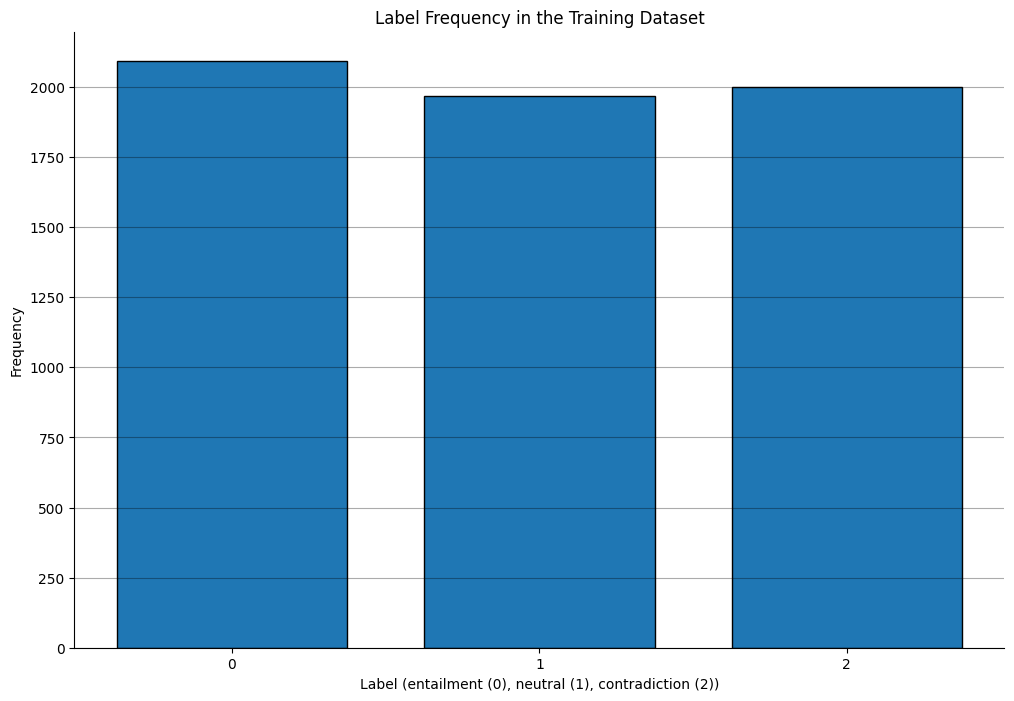

In [12]:
labels = electra_multi_dataset.label.to_numpy()

plt.figure(figsize=(12, 8))

plt.hist(labels, bins=range(4), align="left", rwidth=0.75, edgecolor="black")

plt.xticks(numpy.arange(3))

for pos in ["top", "right"]:
    plt.gca().spines[pos].set_visible(False)

plt.grid(axis="y", alpha=0.33, color="black")

plt.xlabel("Label (entailment (0), neutral (1), contradiction (2))")

plt.ylabel("Frequency")

plt.title("Label Frequency in the Training Dataset")

plt.show()

- From the historgram above, it seams that the most frequent premise is an entailment, while a neutral conclusion happens the least.

In [13]:
def get_length_of_text(_text):
    return len(_text)


length_of_hypothesis_texts = electra_multi_dataset.hypothesis.apply(get_length_of_text)

length_of_premise_texts = electra_multi_dataset.premise.apply(get_length_of_text)

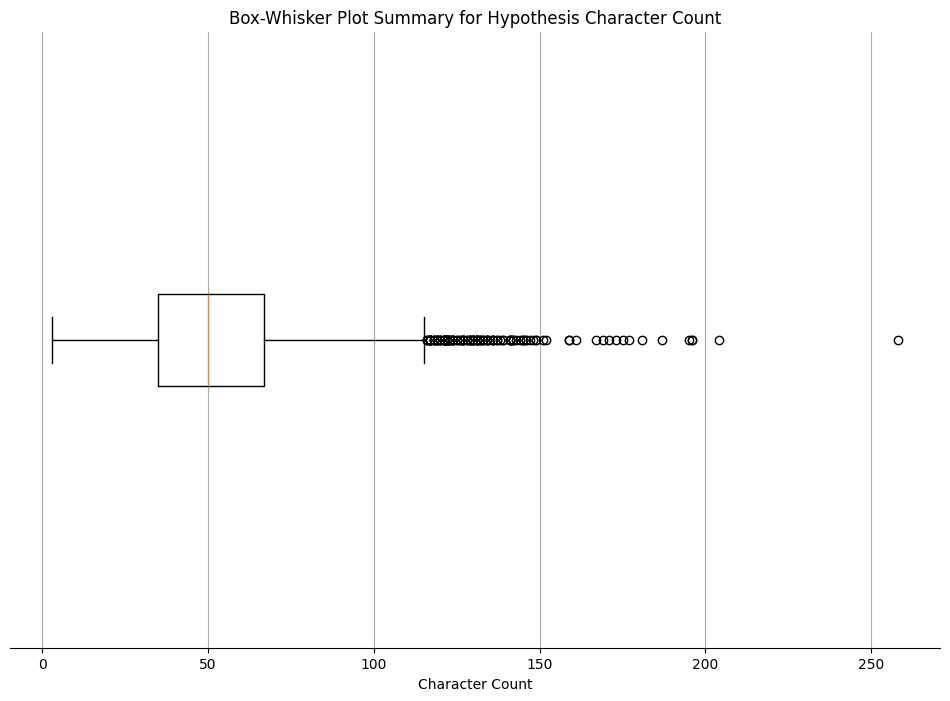

In [14]:
plt.figure(figsize=(12, 8))

plt.boxplot(length_of_hypothesis_texts, vert=False)

for pos in ["top", "right", "left"]:
    plt.gca().spines[pos].set_visible(False)

plt.gca().get_yaxis().set_visible(False)

plt.grid(axis="x", alpha=0.33, color="black")

plt.xlabel("Character Count")

plt.title("Box-Whisker Plot Summary for Hypothesis Character Count")

plt.show()

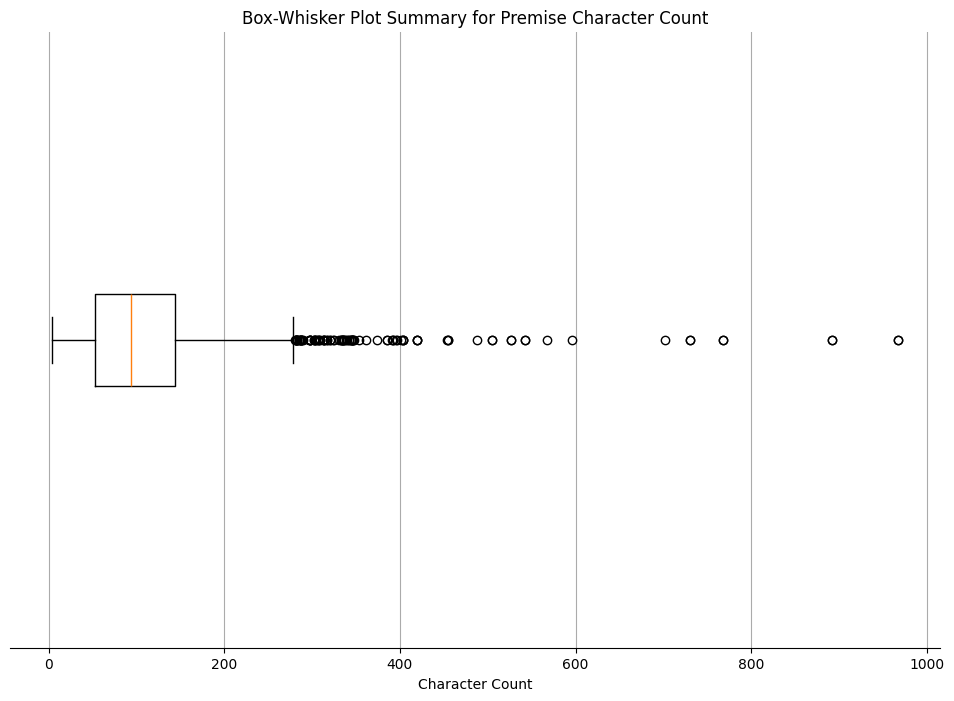

In [15]:
plt.figure(figsize=(12, 8))

plt.boxplot(length_of_premise_texts, vert=False)

for pos in ["top", "right", "left"]:
    plt.gca().spines[pos].set_visible(False)

plt.gca().get_yaxis().set_visible(False)

plt.grid(axis="x", alpha=0.33, color="black")

plt.xlabel("Character Count")

plt.title("Box-Whisker Plot Summary for Premise Character Count")

plt.show()

- From the summary plots of the character counts in the texts, it can be seen that there appear to be many outliers in the distribution. This means that there exists several text elements that are much longer than upper limits of the distribution. This may affect the encoding of the textual embeddings in the model.

- Otherwise, it would seem on average that the premises are longer than the hypotheses.

#### Model Definition

In [16]:
def split_labels(x, y):
    return (x[0], x[1]), y

def process_labels_and_predictions(datalist, logits):
    predictions = tensorflow.argmax(tensorflow.nn.softmax(logits, 1), 1).numpy()

    first_label_set_processed = False

    labels = None

    for i in range(len(datalist)):
        if not first_label_set_processed:
            labels = datalist[i][1].numpy()

            first_label_set_processed = True
        else:
            labels = numpy.hstack((labels, datalist[i][1].numpy()))

    return labels, predictions


def get_max_token_length(dataset, preprocessor):
  token_lengths = []

  for hypothesis, premise in dataset[["hypothesis", "premise"]].values:

    encoded = preprocessor([hypothesis, premise])
    encoded_np = encoded["padding_mask" ]. numpy()
    non_padding_count = encoded_np.sum()
    token_lengths.append(non_padding_count)

  return max(token_lengths)


def plot_model_result(_losses, _accuracies, batch_size, _is_training=True):
    plt.style.use('seaborn-v0_8-dark')

    fig, (momentum_loss_ax, momentum_acc_ax) = plt.subplots(1, 2, figsize=(16,6))
    momentum_loss_ax.plot(numpy.arange(1, len(_losses) + 1), _losses)
    momentum_loss_ax.set_xlabel(f"Epoch (Batch size = {batch_size})")
    momentum_loss_ax.set_xticks(numpy.arange(1, len(_losses) + 1))
    momentum_loss_ax.set_ylabel("CCE loss")
    momentum_loss_ax.set_title(f"{'Training' if _is_training else 'Validation'} Epoch vs. Loss for ELECTRA Multi")
    momentum_loss_ax.grid()

    momentum_acc_ax.plot(numpy.arange(1, len(_accuracies) + 1), _accuracies)
    momentum_acc_ax.set_xlabel(f"Epoch (Batch size = {batch_size})")
    momentum_acc_ax.set_xticks(numpy.arange(1, len(_accuracies) + 1))
    momentum_acc_ax.set_ylabel("Accuracy (%)")
    momentum_acc_ax.set_yticks(numpy.arange(0, 1.1, .1))
    momentum_acc_ax.set_title(f"{'Training' if _is_training else 'Validation'} Epoch vs. Accuracy for ELECTRA Multi")
    momentum_acc_ax.grid()

    plt.show()

def plot_metrics():
  validation_logits = bert_classifier.predict(val_set)
  validation_set_list = list(val_set)
  labels, predictions = process_labels_and_predictions(validation_set_list, validation_logits)

  print(sklearn.metrics.classification_report(labels, predictions, target_names=label_names))

  matrix = sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(labels, predictions), display_labels=label_names)
  matrix.plot()

  plt.show()


In [17]:
VALIDATION_SPLIT = 0.2
TRAIN_SIZE = int(electra_multi_dataset.shape[0] * (1-VALIDATION_SPLIT))

training_dataset = (
    tensorflow.data.Dataset.from_tensor_slices(
        (
            electra_multi_dataset[["hypothesis", "premise"]].values,
            electra_multi_dataset["label"].values
        )
    )
)

train_dataset = training_dataset.take(TRAIN_SIZE)
val_dataset = training_dataset.skip(TRAIN_SIZE)

batch_size = 32

num_epochs = 5

train_preprocessed = train_dataset.map(split_labels, tensorflow.data.AUTOTUNE).cache().shuffle(buffer_size=batch_size, seed=42).batch(batch_size, drop_remainder=True).prefetch(tensorflow.data.AUTOTUNE)
val_preprocessed = val_dataset.map(split_labels, tensorflow.data.AUTOTUNE).cache().shuffle(buffer_size=batch_size, seed=42).batch(batch_size, drop_remainder=True).prefetch(tensorflow.data.AUTOTUNE)

100%|██████████| 546/546 [00:00<00:00, 203kB/s]


100%|██████████| 559/559 [00:00<00:00, 1.16MB/s]


100%|██████████| 226k/226k [00:00<00:00, 291kB/s]


100%|██████████| 418M/418M [00:28<00:00, 15.4MB/s]


Epoch 1/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 149s 435ms/step - loss: 1.0960 - sparse_categorical_accuracy: 0.3486 - val_loss: 0.9602 - val_sparse_categorical_accuracy: 0.5127
Epoch 2/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 57s 378ms/step - loss: 0.8989 - sparse_categorical_accuracy: 0.5293 - val_loss: 0.8589 - val_sparse_categorical_accuracy: 0.6022
Epoch 3/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 57s 378ms/step - loss: 0.7019 - sparse_categorical_accuracy: 0.6534 - val_loss: 0.9513 - val_sparse_categorical_accuracy: 0.5777
Epoch 4/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 57s 377ms/step - loss: 0.5919 - sparse_categorical_accuracy: 0.6873 - val_loss: 0.9625 - val_sparse_categorical_accuracy: 0.5971
Epoch 5/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 57s 378ms/step - loss: 0.5339 - sparse_categorical_accuracy: 0.7109 - val_loss: 1.0584 - val_sparse_categorical_accuracy: 0.5752


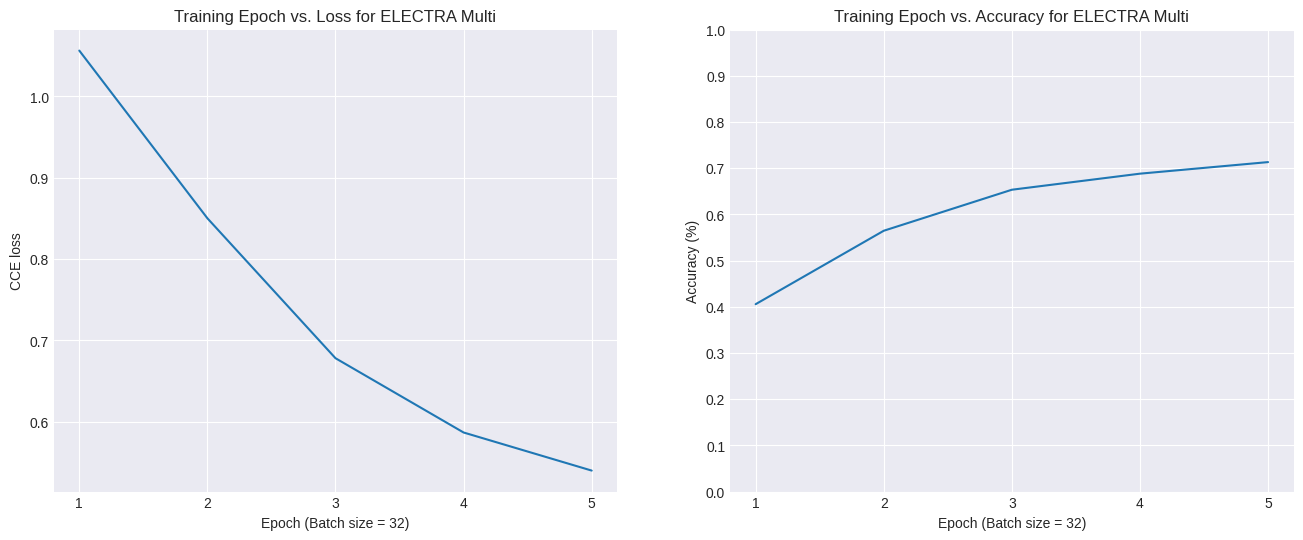

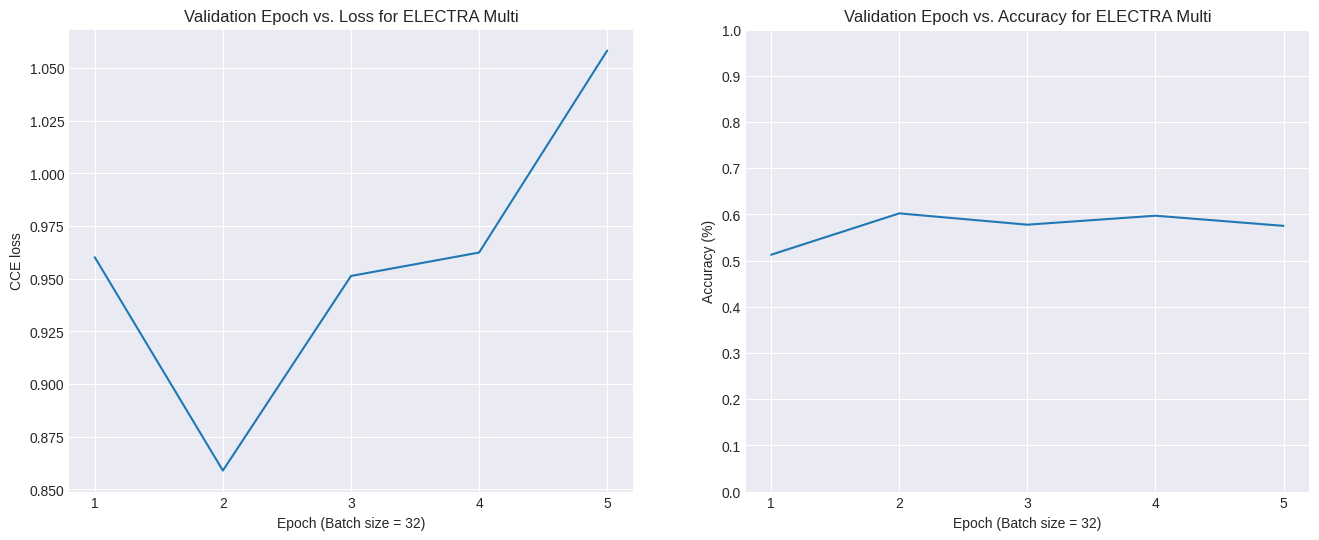

In [18]:
electra_discriminator_token = keras_nlp.models.Tokenizer.from_preset("electra_base_discriminator_uncased_en")
bert_preprocessor = keras_nlp.models.BertTextClassifierPreprocessor(electra_discriminator_token, sequence_length=240)
train_set = (
    train_preprocessed.map(bert_preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE)
)

val_set = (
    val_preprocessed.map(bert_preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE)
)

electra_discriminator_back = keras_nlp.models.Backbone.from_preset("electra_base_discriminator_uncased_en")
bert_classifier = keras_nlp.models.BertClassifier(electra_discriminator_back, 3, preprocessor=None)
classifier_history = bert_classifier.fit(train_set, epochs=5, validation_data=val_set)
training_losses = classifier_history.history["loss"]

training_accuracies = classifier_history.history["sparse_categorical_accuracy"]

validation_losses = classifier_history.history["val_loss"]

validation_accuracies = classifier_history.history["val_sparse_categorical_accuracy"]

plot_model_result(training_losses, training_accuracies, batch_size)

plot_model_result(validation_losses, validation_accuracies, batch_size, False)

#### Optimizer and Loss selection will remain set to the defaults of the preset

37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step
               precision    recall  f1-score   support

   entailment       0.51      0.86      0.64       402
      neutral       0.61      0.39      0.48       404
contradiction       0.73      0.47      0.57       378

     accuracy                           0.58      1184
    macro avg       0.62      0.57      0.56      1184
 weighted avg       0.61      0.58      0.56      1184



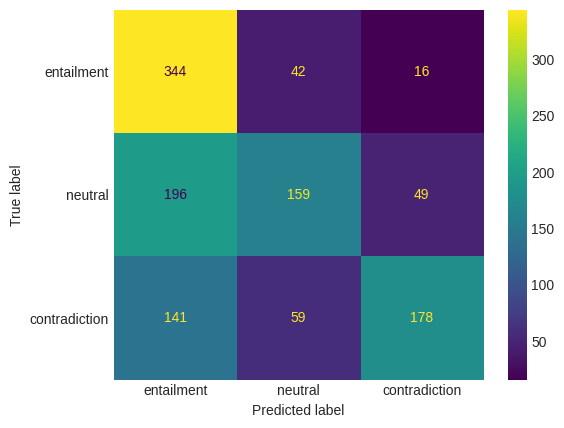

None


In [19]:
print(plot_metrics())

#### Saving the Model

In [ ]:
# Note that only the classifier requires the weights to be saved.
# No training is being done on the tokenizer or preprocessor since we are interested in pretraining the classifier.
dir_path = "Models/ELECTRA"
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

bert_classifier.save_weights("Models/ELECTRA/ELECTRA_EN.weights.h5")